# Table of contents

1. [Load the dataset](#load_the_dataset)
2. [Split the dataset](#split_the_dataset)
3. [Fitting the recommender](#fitting)
4. [Sequential evaluation](#seq_evaluation)  
    4.1 [Evaluation with sequentially revaeled user profiles](#eval_seq_rev)  
    4.2 [Evaluation with "static" user profiles](#eval_static)  
5. [Analysis of next-item recommendation](#next-item)  
    5.1 [Evaluation with different recommendation list lengths](#next-item_list_length)  
    5.2 [Evaluation with different user profile lengths](#next-item_profile_length)

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import datetime
import os
import time
from collections import Counter
import numpy as np
import pandas as pd
import random
from scipy.sparse import find
import logging
import gensim
import numpy as np
from tqdm import tqdm
import datetime
%matplotlib inline

In [31]:
def remove_duplicates(l):
    return [list(x) for x in set(tuple(x) for x in l)]

def count_a_in_b_unique(a, b):
    """
    :param a: list of lists
    :param b: list of lists
    :return: number of elements of a in b
    """
    count = 0
    for el in a:
        if el in b:
            count += 1
    return count

def sequential_evaluation(recommender,
                          test_sequences,
                          evaluation_functions,
                          users=None,
                          given_k=1,
                          look_ahead=1,
                          top_n=10,
                          scroll=True,
                          step=1):
    """
    Runs sequential evaluation of a recommender over a set of test sequences
    :param recommender: the instance of the recommender to test
    :param test_sequences: the set of test sequences
    :param evaluation_functions: list of evaluation metric functions
    :param users: (optional) the list of user ids associated to each test sequence. Required by personalized models like FPMC.
    :param given_k: (optional) the initial size of each user profile, starting from the first interaction in the sequence.
                    If <0, start counting from the end of the sequence. It must be != 0.
    :param look_ahead: (optional) number of subsequent interactions in the sequence to be considered as ground truth.
                    It can be any positive number or 'all' to extend the ground truth until the end of the sequence.
    :param top_n: (optional) size of the recommendation list
    :param scroll: (optional) whether to scroll the ground truth until the end of the sequence.
                If True, expand the user profile and move the ground truth forward of `step` interactions. Recompute and evaluate recommendations every time.
                If False, evaluate recommendations once per sequence without expanding the user profile.
    :param step: (optional) number of interactions that will be added to the user profile at each step of the sequential evaluation.
    :return: the list of the average values for each evaluation metric
    """
    if given_k == 0:
        raise ValueError('given_k must be != 0')

    metrics = np.zeros(len(evaluation_functions))
    with tqdm(total=len(test_sequences)) as pbar:
        for i, test_seq in enumerate(test_sequences):
            if users is not None:
                user = users[i]
            else:
                user = None
            if scroll:
                metrics += sequence_sequential_evaluation(recommender,
                                                          test_seq,
                                                          evaluation_functions,
                                                          user,
                                                          given_k,
                                                          look_ahead,
                                                          top_n,
                                                          step)
            else:
                metrics += evaluate_sequence(recommender,
                                             test_seq,
                                             evaluation_functions,
                                             user,
                                             given_k,
                                             look_ahead,
                                             top_n)
            pbar.update(1)
    return metrics / len(test_sequences)


def evaluate_sequence(recommender, seq, evaluation_functions, user, given_k, look_ahead, top_n):
    """
    :param recommender: which recommender to use
    :param seq: the user_profile/ context
    :param given_k: last element used as ground truth. NB if <0 it is interpreted as first elements to keep
    :param evaluation_functions: which function to use to evaluate the rec performance
    :param look_ahead: number of elements in ground truth to consider. if look_ahead = 'all' then all the ground_truth sequence is considered
    :return: performance of recommender
    """
    # safety checks
    if given_k < 0:
        given_k = len(seq) + given_k

    user_profile = seq[:given_k]
    ground_truth = seq[given_k:]

    # restrict ground truth to look_ahead
    ground_truth = ground_truth[:look_ahead] if look_ahead != 'all' else ground_truth
    ground_truth = list(map(lambda x: [x], ground_truth))  # list of list format

    if not user_profile or not ground_truth:
        # if any of the two missing all evaluation functions are 0
        return np.zeros(len(evaluation_functions))

    r = recommender.recommend(user_profile, user)[:top_n]

    if not r:
        # no recommendation found
        return np.zeros(len(evaluation_functions))
    reco_list = recommender.get_recommendation_list(r)

    tmp_results = []
    for f in evaluation_functions:
        tmp_results.append(f(ground_truth, reco_list))
    return np.array(tmp_results)


def sequence_sequential_evaluation(recommender, seq, evaluation_functions, user, given_k, look_ahead, top_n, step):
    if given_k < 0:
        given_k = len(seq) + given_k

    eval_res = 0.0
    eval_cnt = 0
    for gk in range(given_k, len(seq), step):
        eval_res += evaluate_sequence(recommender, seq, evaluation_functions, user, gk, look_ahead, top_n)
        eval_cnt += 1
    return eval_res / eval_cnt

def sequences_to_spfm_format(sequences, tmp_path='tmp/sequences.txt'):
    """
    Convert a list of sequences to SPFM format and write them to `tmp_path`
    :param sequences: the list of sequences
    :param tmp_path: the path where sequences will be written in the SPFM format
    """
    basedir = os.path.split(tmp_path)[0]
    os.makedirs(basedir, exist_ok=True)
    with open(tmp_path, 'w') as fout:
        for s in sequences:
            fout.write(' -1 '.join(map(str, s)))
            fout.write(' -2\n')

def create_seq_db_filter_top_k(path, topk=0, last_months=0):
    file = load_and_adapt(path, last_months=last_months)
    file['item_id'] = file['item_id'].astype(str)

    c = Counter(list(file['item_id']))

    if topk > 1:
        keeper = set([x[0] for x in c.most_common(topk)])
        file = file[file['item_id'].isin(keeper)]
    print(file[file["session_id"] == 357])
    # group by session id and concat song_id
    groups = file.groupby('session_id')
    print("groups", groups.count())
    aggregated = pd.DataFrame(groups['item_id'].agg( lambda x: list(x)))
    aggregated.rename(columns = {'item_id':'sequence'}, inplace = True)

    print("aggregated", aggregated.head(10))
    init_ts = pd.DataFrame(groups['ts'].min())
    users = pd.DataFrame(groups['user_id'].min())  # it's just fast, min doesn't actually make sense
    print("init_ts", init_ts, "users", users)
    result = aggregated.join(init_ts).join(users)

    print(result.head())
    result.reset_index(inplace=True)
    return result

def last_session_out_split(data,
                           user_key='user_id',
                           session_key='session_id',
                           time_key='ts'):
    """
    Assign the last session of every user to the test set and the remaining ones to the training set
    """
    sessions = data.sort_values(by=[user_key, time_key]).groupby(user_key)[session_key]
    last_session = sessions.last()
    train = data[~data.session_id.isin(last_session.values)].copy()
    test = data[data.session_id.isin(last_session.values)].copy()
    train, test = clean_split(train, test)
    return train, test

def precision(ground_truth, prediction):
    """
    Compute Precision metric
    :param ground_truth: the ground truth set or sequence
    :param prediction: the predicted set or sequence
    :return: the value of the metric
    """
    ground_truth = remove_duplicates(ground_truth)
    prediction = remove_duplicates(prediction)
    precision_score = count_a_in_b_unique(prediction, ground_truth) / float(len(prediction))
    assert 0 <= precision_score <= 1
    return precision_score

def recall(ground_truth, prediction):
    """
    Compute Recall metric
    :param ground_truth: the ground truth set or sequence
    :param prediction: the predicted set or sequence
    :return: the value of the metric
    """
    ground_truth = remove_duplicates(ground_truth)
    prediction = remove_duplicates(prediction)
    recall_score = 0 if len(prediction) == 0 else count_a_in_b_unique(prediction, ground_truth) / float(
        len(ground_truth))
    assert 0 <= recall_score <= 1
    return recall_score

def mrr(ground_truth, prediction):
    """
    Compute Mean Reciprocal Rank metric. Reciprocal Rank is set 0 if no predicted item is in contained the ground truth.
    :param ground_truth: the ground truth set or sequence
    :param prediction: the predicted set or sequence
    :return: the value of the metric
    """
    rr = 0.
    for rank, p in enumerate(prediction):
        if p in ground_truth:
            rr = 1. / (rank + 1)
            break
    return rr

class ISeqRecommender(object):
    """Abstract Recommender class"""

    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger()

    def __init__(self):
        super(ISeqRecommender, self).__init__()

    def fit(self, train_data):
        pass

    def recommend(self, user_profile, user_id=None):
        """
        Given the user profile return a list of recommendation
        :param user_profile: the user profile as a list of item identifiers
        :param user_id: (optional) the user id
        :return: list of recommendations e.g. [([2], 0.875), ([6], 1.0)]
        """
        pass

    @staticmethod
    def get_recommendation_list(recommendation):
        return list(map(lambda x: x[0], recommendation))

    @staticmethod
    def get_recommendation_confidence_list(recommendation):
        return list(map(lambda x: x[1], recommendation))

    def activate_debug_print(self):
        self.logger.setLevel(logging.DEBUG)

    def deactivate_debug_print(self):
        self.logger.setLevel(logging.INFO)

class Prod2VecRecommender(ISeqRecommender):
    """
    Implementation of the Prod2Vec skipgram model from
    Grbovic Mihajlo, Vladan Radosavljevic, Nemanja Djuric, Narayan Bhamidipati, Jaikit Savla, Varun Bhagwan, and Doug Sharp.
    "E-commerce in your inbox: Product recommendations at scale."
    In Proceedings of the 21th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining,
    pp. 1809-1818. ACM, 2015.
    """

    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    def __init__(self, min_count=2, size=100, window=5, decay_alpha=0.9, workers=4):
        """
        :param min_count: (optional) the minimum item frequency. Items less frequent that min_count will be pruned
        :param size: (optional) the size of the embeddings
        :param window: (optional) the size of the context window
        :param decay_alpha: (optional) the exponential decay factor used to discount the similarity scores for items
                back in the user profile. Lower values mean higher discounting of past user interactions. Allows values in [0-1].
        :param workers: (optional) the number of threads used for training
        """
        super(Prod2VecRecommender, self).__init__()
        self.min_count = min_count
        self.size = size
        self.window = window
        self.decay_alpha = decay_alpha
        self.workers = workers

    def __str__(self):
        return 'Prod2VecRecommender(min_count={min_count}, ' \
               'size={size}, ' \
               'window={window}, ' \
               'decay_alpha={decay_alpha}, ' \
               'workers={workers})'.format(**self.__dict__)

    def fit(self, train_data):
        sequences = train_data['sequence'].values
        self.model = gensim.models.Word2Vec(sequences,
                                            min_count=self.min_count,
                                            window=self.window,
                                            hs=1,
                                            size=self.size,
                                            sg=1,
                                            workers=self.workers)

    def recommend(self, user_profile, user_id=None):
        user_profile = list(map(str, user_profile))
        rec = []
        try:
            # iterate the user profile backwards
            for i, item in enumerate(user_profile[::-1]):
                ms = self.model.most_similar(positive=item)
                # apply exponential decay to the similarity scores
                decay = self.decay_alpha ** i
                ms = [(x[0], decay * x[1]) for x in ms]
                rec.extend(ms)
            # sort items by similarity score
            rec = sorted(rec, key=lambda x: -x[1])
        except KeyError:
            rec = []
        return [([x[0]], x[1]) for x in rec]

def load_and_adapt(path, last_months=0):
    file_ext = os.path.splitext(path)[-1]
    if file_ext == '.csv':
        data = pd.read_csv(path, header=0)
    elif file_ext == '.hdf':
        data = pd.read_hdf(path)
    else:
        raise ValueError('Unsupported file {} having extension {}'.format(path, file_ext))

    col_names = ['session_id', 'user_id', 'item_id', 'ts'] + data.columns.values.tolist()[4:]
    data.columns = col_names

    if last_months > 0:
        def add_months(sourcedate, months):
            month = sourcedate.month - 1 + months
            year = int(sourcedate.year + month / 12)
            month = month % 12 + 1
            day = min(sourcedate.day, calendar.monthrange(year, month)[1])
            return datetime.date(year, month, day)

        lastdate = datetime.datetime.fromtimestamp(data.ts.max())
        firstdate = add_months(lastdate, -last_months)
        initial_unix = time.mktime(firstdate.timetuple())

        # filter out older interactions
        data = data[data['ts'] >= initial_unix]

    return data

def clean_split(train, test):
    """
    Remove new items from the test set.
    :param train: The training set.
    :param test: The test set.
    :return: The cleaned training and test sets.
    """
    train_items = set()
    train['sequence'].apply(lambda seq: train_items.update(set(seq)))
    test['sequence'] = test['sequence'].apply(lambda seq: [it for it in seq if it in train_items])
    return train, test

In [32]:
def get_test_sequences(test_data, given_k):
    # we can run evaluation only over sequences longer than abs(LAST_K)
    test_sequences = test_data.loc[test_data['sequence'].map(len) > abs(given_k), 'sequence'].values
    return test_sequences

<a id='load_the_dataset'></a>

# 1. Load the dataset

For this hands-on session we will use a dataset of user-listening sessions crawled from [last.fm](https://www.last.fm/). In detail, we will use a subset of the following dataset:

* 30Music listening and playlists dataset, Turrin et al., ACM RecSys 2015 ([paper](https://home.deib.polimi.it/pagano/portfolio/papers/30Musiclisteningandplaylistsdataset.pdf))

In [33]:
# unzip the dataset, if you haven't already done it
# ! unzip datasets/sessions.zip -d datasets

In [34]:
dataset_path = 'datasets/sessions_sample_10.csv'
# load this sample if you experience a severe slowdown with the previous dataset
#dataset_path = 'datasets/sessions_sample_10.csv'

# for the sake of speed, let's keep only the top-1k most popular items in the last month
dataset = create_seq_db_filter_top_k(path=dataset_path, topk=1000, last_months=1) 

        session_id  user_id item_id          ts  playtime
169856         357     4296     793  1421003874       101
169857         357     4296    3489  1421006174       308
groups             user_id  item_id  ts  playtime
session_id                                
357               2        2   2         2
359               1        1   1         1
394               1        1   1         1
4127              6        6   6         6
6400              2        2   2         2
...             ...      ...  ..       ...
2758111           1        1   1         1
2758373           1        1   1         1
2761080           2        2   2         2
2762214           2        2   2         2
2762867           3        3   3         3

[6825 rows x 4 columns]
aggregated                                         sequence
session_id                                      
357                                  [793, 3489]
359                                       [1762]
394                         

Let's see at how the dataset looks like

In [35]:
dataset.head()

,session_id,sequence,ts,user_id
0,357,"[793, 3489]",1421003874,4296
1,359,[1762],1421018535,4296
2,394,[1256],1421007470,30980
3,4127,"[1948, 1364, 2060, 1115, 6488, 2060]",1421416896,28117
4,6400,"[687, 1394]",1420807778,35247


Let's show some statistics about the dataset

In [36]:
from collections import Counter
cnt = Counter()
dataset.sequence.map(cnt.update);

In [37]:
sequence_length = dataset.sequence.map(len).values
n_sessions_per_user = dataset.groupby('user_id').size()

print('Number of items: {}'.format(len(cnt)))
print('Number of users: {}'.format(dataset.user_id.nunique()))
print('Number of sessions: {}'.format(len(dataset)) )

print('\nSession length:\n\tAverage: {:.2f}\n\tMedian: {}\n\tMin: {}\n\tMax: {}'.format(
    sequence_length.mean(), 
    np.quantile(sequence_length, 0.5), 
    sequence_length.min(), 
    sequence_length.max()))

print('Sessions per user:\n\tAverage: {:.2f}\n\tMedian: {}\n\tMin: {}\n\tMax: {}'.format(
    n_sessions_per_user.mean(), 
    np.quantile(n_sessions_per_user, 0.5), 
    n_sessions_per_user.min(), 
    n_sessions_per_user.max()))

Number of items: 1000
Number of users: 4196
Number of sessions: 6825

Session length:
	Average: 4.27
	Median: 3.0
	Min: 1
	Max: 148
Sessions per user:
	Average: 1.63
	Median: 1.0
	Min: 1
	Max: 13


In [38]:
print('Most popular items: {}'.format(cnt.most_common(5)))

Most popular items: [('443', 207), ('1065', 156), ('67', 146), ('2308', 138), ('658', 131)]


<a id='split_the_dataset'></a>

# 2. Split the dataset

For simplicity, let's split the dataset by assigning the **last session** of every user to the **test set**, and **all the previous** ones to the **training set**.

In [39]:
train_data, test_data = last_session_out_split(dataset)
print("Train sessions: {} - Test sessions: {}".format(len(train_data), len(test_data)))

Train sessions: 2629 - Test sessions: 4196


<a id='fitting'></a>

# 3. Fitting the recommender

Here we fit the recommedation algorithm over the sessions in the training set.  

This is simplified implementation of the following:

_Grbovic, Mihajlo, Vladan Radosavljevic, Nemanja Djuric, Narayan Bhamidipati,
Jaikit Savla, Varun Bhagwan, and Doug Sharp. "E-commerce in your inbox: Product recommendations at scale."
 In Proceedings of the 21th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, pp. 1809-1818. ACM, 2015._
 
This implementation uses the `gensim` implementation of Word2Vec to compute item embeddings using the skip-gram model, as depicted below:

<img src="images/prod2vec.png" width="250px" />

Recommendations are generated by returning the k-nearest neighbors of the last items in the user profile, whose relevance is weighted using a simple *exponential decay* (the *last item* in the user profile is the *most relevant* one, and the *first item* the *least relevant*).

The original paper contains other variants of this algorithm (namely bagged-prod2vec and prod2vec-cluster) which are not subject of this tutorial. 

The class `Prod2VecRecommender` has the following initialization hyper-parameters:
* `min_count`: the minimum item frequency. Items less frequent that min_count will be pruned
* `size`: the size of the embeddings
* `window`: the size of the context window
* `decay_alpha`: the exponential decay factor used to discount the similarity scores for items  back in the user profile. Lower values mean higher discounting of past user interactions. Allows values in [0-1]
* `workers`: the number of threads used for training


In [40]:
recommender = Prod2VecRecommender(min_count=2, 
                                  size=50, 
                                  window=5,
                                  decay_alpha=0.9,
                                  workers=4)
recommender.fit(train_data)

2022-02-03 22:51:59,925 - WARNING - consider setting layer size to a multiple of 4 for greater performance
2022-02-03 22:51:59,929 - INFO - collecting all words and their counts
2022-02-03 22:51:59,933 - INFO - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-02-03 22:51:59,950 - INFO - collected 999 word types from a corpus of 12240 raw words and 2629 sentences
2022-02-03 22:51:59,953 - INFO - Loading a fresh vocabulary
2022-02-03 22:51:59,960 - INFO - min_count=2 retains 996 unique words (99% of original 999, drops 3)
2022-02-03 22:51:59,962 - INFO - min_count=2 leaves 12237 word corpus (99% of original 12240, drops 3)
2022-02-03 22:51:59,976 - INFO - deleting the raw counts dictionary of 999 items
2022-02-03 22:51:59,979 - INFO - sample=0.001 downsamples 34 most-common words
2022-02-03 22:51:59,982 - INFO - downsampling leaves estimated 11933 word corpus (97.5% of prior 12237)
2022-02-03 22:51:59,987 - INFO - constructing a huffman tree from 996 words
2022-02-0

<a id='seq_evaluation'></a>


# 4. Sequential evaluation

In the evaluation of sequence-aware recommenders, each sequence in the test set is split into:
- the _user profile_, used to compute recommendations, is composed by the first *k* events in the sequence;
- the _ground truth_, used for performance evaluation, is composed by the remainder of the sequence.

In the cells below, you can control the dimension of the _user profile_ by assigning a **positive** value to `GIVEN_K`, which correspond to the number of events from the beginning of the sequence that will be assigned to the initial user profile. This ensures that each user profile in the test set will have exactly the same initial size, but the size of the ground truth will change for every sequence.

Alternatively, by assigning a **negative** value to `GIVEN_K`, you will set the initial size of the _ground truth_. In this way the _ground truth_ will have the same size for all sequences, but the dimension of the user profile will differ.

In [41]:
METRICS = {'precision':precision, 
           'recall':recall,
           'mrr': mrr}
TOPN = 10 # length of the recommendation list

<a id='eval_seq_rev'></a>

## 4.1 Evaluation with sequentially revealed user-profiles

Here we evaluate the quality of the recommendations in a setting in which user profiles are revealed _sequentially_.

The _user profile_ starts from the first `GIVEN_K` events (or, alternatively, from the last `-GIVEN_K` events if `GIVEN_K<0`).  
The recommendations are evaluated against the next `LOOK_AHEAD` events (the _ground truth_).  
The _user profile_ is next expanded to the next `STEP` events, the ground truth is scrolled forward accordingly, and the evaluation continues until the sequence ends.

In typical **next-item recommendation**, we start with `GIVEN_K=1`, generate a set of **alternatives** that will evaluated against the next event in the sequence (`LOOK_AHEAD=1`), move forward of one step (`STEP=1`) and repeat until the sequence ends.

You can set the `LOOK_AHEAD='all'` to see what happens if you had to recommend a **whole sequence** instead of a set of a set of alternatives to a user.

NOTE: Metrics are averaged over each sequence first, then averaged over all test sequences.

** (TODO) Try out with different evaluation settings to see how the recommandation quality changes. **


![](gifs/sequential_eval.gif)

In [42]:
# GIVEN_K=1, LOOK_AHEAD=1, STEP=1 corresponds to the classical next-item evaluation
GIVEN_K = 1
LOOK_AHEAD = 1
STEP = 1

In [43]:
test_sequences = get_test_sequences(test_data, GIVEN_K)
print('{} sequences available for evaluation'.format(len(test_sequences)))

results = sequential_evaluation(recommender,
                               test_sequences=test_sequences,
                               given_k=GIVEN_K,
                               look_ahead=LOOK_AHEAD,
                               evaluation_functions=METRICS.values(),
                               top_n=TOPN,
                               scroll=True,  # scrolling averages metrics over all profile lengths
                               step=STEP)

2905 sequences available for evaluation


  0%|                                                                                         | 0/2905 [00:00<?, ?it/s]C:\Users\sunny\AppData\Local\Temp\ipykernel_8100\2595860117.py:300: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  ms = self.model.most_similar(positive=item)
2022-02-03 22:52:01,927 - INFO - precomputing L2-norms of word weight vectors
100%|██████████████████████████████████████████████████████████████████████████████| 2905/2905 [00:58<00:00, 49.57it/s]


In [44]:
print('Sequential evaluation (GIVEN_K={}, LOOK_AHEAD={}, STEP={})'.format(GIVEN_K, LOOK_AHEAD, STEP))
for mname, mvalue in zip(METRICS.keys(), results):
    print('\t{}@{}: {:.4f}'.format(mname, TOPN, mvalue))

Sequential evaluation (GIVEN_K=1, LOOK_AHEAD=1, STEP=1)
	precision@10: 0.0241
	recall@10: 0.2317
	mrr@10: 0.0959


<a id='eval_static'></a>

## 4.2 Evaluation with "static" user-profiles

Here we evaluate the quality of the recommendations in a setting in which user profiles are instead _static_.

The _user profile_ starts from the first `GIVEN_K` events (or, alternatively, from the last `-GIVEN_K` events if `GIVEN_K<0`).  
The recommendations are evaluated against the next `LOOK_AHEAD` events (the _ground truth_).  

The user profile is *not extended* and the ground truth *doesn't move forward*.
This allows to obtain "snapshots" of the recommendation performance for different user profile and ground truth lenghts.

Also here you can set the `LOOK_AHEAD='all'` to see what happens if you had to recommend a **whole sequence** instead of a set of a set of alternatives to a user.

**(TODO) Try out with different evaluation settings to see how the recommandation quality changes.**

In [45]:
GIVEN_K = 1
LOOK_AHEAD = 1
STEP=1

In [46]:
test_sequences = get_test_sequences(test_data, GIVEN_K)
print('{} sequences available for evaluation'.format(len(test_sequences)))

results = sequential_evaluation(recommender,
                               test_sequences=test_sequences,
                               given_k=GIVEN_K,
                               look_ahead=LOOK_AHEAD,
                               evaluation_functions=METRICS.values(),
                               top_n=TOPN,
                               scroll=False  # notice that scrolling is disabled!
                              )  

2905 sequences available for evaluation


  0%|                                                                                         | 0/2905 [00:00<?, ?it/s]C:\Users\sunny\AppData\Local\Temp\ipykernel_8100\2595860117.py:300: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  ms = self.model.most_similar(positive=item)
100%|████████████████████████████████████████████████████████████████████████████| 2905/2905 [00:02<00:00, 1129.28it/s]


In [47]:
print('Sequential evaluation (GIVEN_K={}, LOOK_AHEAD={}, STEP={})'.format(GIVEN_K, LOOK_AHEAD, STEP))
for mname, mvalue in zip(METRICS.keys(), results):
    print('\t{}@{}: {:.4f}'.format(mname, TOPN, mvalue))

Sequential evaluation (GIVEN_K=1, LOOK_AHEAD=1, STEP=1)
	precision@10: 0.0214
	recall@10: 0.2145
	mrr@10: 0.0818


<a id='next-item'></a>

## 5. Analysis of next-item recommendation

Here we propose to analyse the performance of the recommender system in the scenario of *next-item recommendation* over the following dimensions:

* the *length* of the **recommendation list**, and
* the *length* of the **user profile**.

NOTE: This evaluation is by no means exhaustive, as different the hyper-parameters of the recommendation algorithm should be *carefully tuned* before drawing any conclusions. Unfortunately, given the time constraints for this tutorial, we had to leave hyper-parameter tuning out. A very useful reference about careful evaluation of (session-based) recommenders can be found at:

*  Evaluation of Session-based Recommendation Algorithms, Ludewig and Jannach, 2018 ([paper](https://arxiv.org/abs/1803.09587))

<a id='next-item_list_length'></a>

### 5.1 Evaluation for different recommendation list lengths

In [48]:
GIVEN_K = 1
LOOK_AHEAD = 1
STEP = 1
topn_list = [1, 5, 10, 20, 50, 100]

In [49]:
# ensure that all sequences have the same minimum length 
test_sequences = get_test_sequences(test_data, GIVEN_K)
print('{} sequences available for evaluation'.format(len(test_sequences)))

2905 sequences available for evaluation


In [50]:
res_list = []

for topn in topn_list:
    print('Evaluating recommendation lists with length: {}'.format(topn))
    res_tmp = sequential_evaluation(recommender,
                                   test_sequences=test_sequences,
                                   given_k=GIVEN_K,
                                   look_ahead=LOOK_AHEAD,
                                   evaluation_functions=METRICS.values(),
                                   top_n=topn,
                                   scroll=True,  # here we average over all profile lengths
                                   step=STEP)
    mvalues = list(zip(METRICS.keys(), res_tmp))
    res_list.append((topn, mvalues))

Evaluating recommendation lists with length: 1


  0%|                                                                                         | 0/2905 [00:00<?, ?it/s]C:\Users\sunny\AppData\Local\Temp\ipykernel_8100\2595860117.py:300: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  ms = self.model.most_similar(positive=item)
100%|██████████████████████████████████████████████████████████████████████████████| 2905/2905 [00:58<00:00, 49.68it/s]


Evaluating recommendation lists with length: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2905/2905 [00:54<00:00, 53.77it/s]


Evaluating recommendation lists with length: 10


100%|██████████████████████████████████████████████████████████████████████████████| 2905/2905 [00:54<00:00, 53.03it/s]


Evaluating recommendation lists with length: 20


100%|██████████████████████████████████████████████████████████████████████████████| 2905/2905 [00:54<00:00, 53.02it/s]


Evaluating recommendation lists with length: 50


100%|██████████████████████████████████████████████████████████████████████████████| 2905/2905 [00:55<00:00, 52.29it/s]


Evaluating recommendation lists with length: 100


100%|██████████████████████████████████████████████████████████████████████████████| 2905/2905 [00:55<00:00, 52.44it/s]


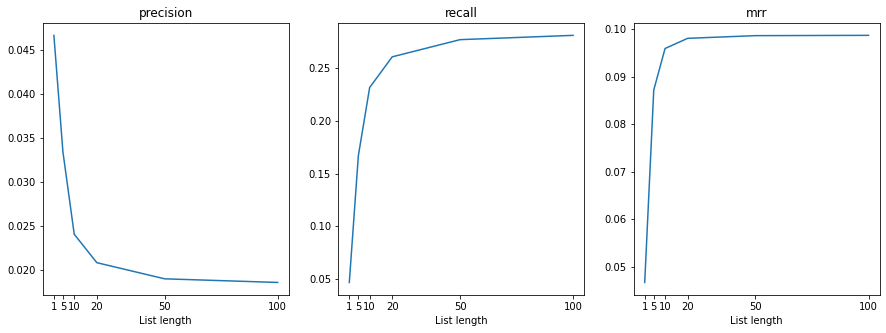

In [51]:
# show separate plots per metric
fig, axes = plt.subplots(nrows=1, ncols=len(METRICS), figsize=(15,5))
res_list_t = list(zip(*res_list))
for midx, metric in enumerate(METRICS):
    mvalues = [res_list_t[1][j][midx][1] for j in range(len(res_list_t[1]))]
    ax = axes[midx]
    ax.plot(topn_list, mvalues)
    ax.set_title(metric)
    ax.set_xticks(topn_list)
    ax.set_xlabel('List length')

<a id='next-item_profile_length'></a>

### 5.2 Evaluation for different user profile lengths

In [52]:
given_k_list = [1, 2, 3, 4]
LOOK_AHEAD = 1
STEP = 1
TOPN = 10

In [53]:
# ensure that all sequences have the same minimum length 
test_sequences = get_test_sequences(test_data, max(given_k_list))
print('{} sequences available for evaluation'.format(len(test_sequences)))

res_list = []

for gk in given_k_list:
    print('Evaluating profiles having length: {}'.format(gk))
    res_tmp = sequential_evaluation(recommender,
                                   test_sequences=test_sequences,
                                   given_k=gk,
                                   look_ahead=LOOK_AHEAD,
                                   evaluation_functions=METRICS.values(),
                                   top_n=TOPN,
                                   scroll=False,  # here we stop at each profile length
                                   step=STEP)
    mvalues = list(zip(METRICS.keys(), res_tmp))
    res_list.append((gk, mvalues))

1169 sequences available for evaluation
Evaluating profiles having length: 1


  0%|                                                                                         | 0/1169 [00:00<?, ?it/s]C:\Users\sunny\AppData\Local\Temp\ipykernel_8100\2595860117.py:300: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  ms = self.model.most_similar(positive=item)
100%|████████████████████████████████████████████████████████████████████████████| 1169/1169 [00:00<00:00, 1200.46it/s]


Evaluating profiles having length: 2


100%|█████████████████████████████████████████████████████████████████████████████| 1169/1169 [00:01<00:00, 644.02it/s]


Evaluating profiles having length: 3


100%|█████████████████████████████████████████████████████████████████████████████| 1169/1169 [00:02<00:00, 468.81it/s]


Evaluating profiles having length: 4


100%|█████████████████████████████████████████████████████████████████████████████| 1169/1169 [00:03<00:00, 334.81it/s]


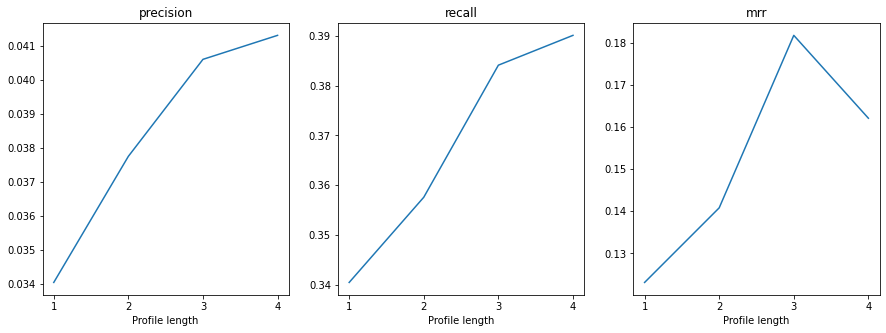

In [54]:
# show separate plots per metric
fig, axes = plt.subplots(nrows=1, ncols=len(METRICS), figsize=(15,5))
res_list_t = list(zip(*res_list))
for midx, metric in enumerate(METRICS):
    mvalues = [res_list_t[1][j][midx][1] for j in range(len(res_list_t[1]))]
    ax = axes[midx]
    ax.plot(given_k_list, mvalues)
    ax.set_title(metric)
    ax.set_xticks(given_k_list)
    ax.set_xlabel('Profile length')